In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

## Model Libraries
from sklearn.tree import DecisionTreeClassifier

In [2]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [3]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [4]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [5]:
X = df.iloc[:, 2:9]

In [6]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [7]:
for col in X:
    X[col] = X[col].astype(int)

In [8]:
X.head()

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,1,1,1,1,0,1,1
1,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,0,0,0,1,0,0
4,1,1,1,1,0,0,0


In [9]:
X.shape

(292, 7)

In [10]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [11]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

## Cross Validation & Hyperparameter Tuning
Adopted from: https://weina.me/nested-cross-validation/

#### Data Splitting

In [12]:
## Divide data into train and "unseen" test set
## Unseen test set will be used for final testing after best hyperparameter sets chose
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(X, y, test_size=0.30, random_state=42)

In [13]:
y_train.value_counts()

0    149
1     55
Name: label, dtype: int64

In [14]:
y_test_unseen.value_counts()

0    66
1    22
Name: label, dtype: int64

#### Find The Best Hyperparameter Candidates

In [15]:
## Define a parameters grid
p_grid = {"max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],\
          "min_samples_split": [2,5,10,15,20,25,30],\
          "min_samples_leaf": [1,3,5,10,15]}

In [16]:
## Split train data to 5 (outer) folds
skfold_outer = StratifiedKFold(n_splits=5)
skfold_inner = StratifiedKFold(n_splits=4)

In [17]:
i = 1
folds = []
for train_index_outer, test_index_outer in skfold_outer.split(X_train, y_train):
    fold_data = {}
    
    print("Outer Fold %s" % i)
    data_X_train = X_train.iloc[train_index_outer]
    data_y_train = y_train.iloc[train_index_outer]
    data_X_test = X_train.iloc[test_index_outer]
    data_y_test = y_train.iloc[test_index_outer]
    
    ## Define model
    model = DecisionTreeClassifier(random_state=0)
    
    ## Do cross validation in inner fold, get the best params
    clf = GridSearchCV(model, p_grid, scoring='roc_auc', cv=skfold_inner)
    clf.fit(data_X_train, data_y_train)
    print("Best Params: %s" % clf.best_params_)
    print("Best Avg. Score: %s" % clf.best_score_)
    fold_data['outer_fold'] = i
    fold_data['best_param'] = clf.best_params_
    fold_data['best_avg_score'] = clf.best_score_
    
    ## Test to test data in outer loop
    model = DecisionTreeClassifier(random_state=0,\
                          min_samples_split=fold_data['best_param']['min_samples_split'],\
                          max_depth=fold_data['best_param']['max_depth'],\
                          min_samples_leaf=fold_data['best_param']['min_samples_leaf'])
    
    model.fit(data_X_train, data_y_train)
    y_pred_proba = model.predict_proba(data_X_test)
    fpr, tpr, thresholds = roc_curve(data_y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    fold_data['test_outer_score'] = auc_score
    print("Test Outer Score: %s" % auc_score)
    
    folds.append(fold_data)
    
    i+=1

Outer Fold 1
Best Params: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 25}
Best Avg. Score: 0.9128657262277952
Test Outer Score: 0.9106060606060606
Outer Fold 2
Best Params: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best Avg. Score: 0.94489289446186
Test Outer Score: 0.7803030303030304
Outer Fold 3
Best Params: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 25}
Best Avg. Score: 0.8918103448275861
Test Outer Score: 0.9333333333333333
Outer Fold 4
Best Params: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best Avg. Score: 0.883346394984326
Test Outer Score: 0.9348484848484848
Outer Fold 5
Best Params: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 15}
Best Avg. Score: 0.8856060606060606
Test Outer Score: 0.9702194357366771


In [18]:
folds

[{'outer_fold': 1,
  'best_param': {'max_depth': 3,
   'min_samples_leaf': 3,
   'min_samples_split': 25},
  'best_avg_score': 0.9128657262277952,
  'test_outer_score': 0.9106060606060606},
 {'outer_fold': 2,
  'best_param': {'max_depth': 4,
   'min_samples_leaf': 1,
   'min_samples_split': 20},
  'best_avg_score': 0.94489289446186,
  'test_outer_score': 0.7803030303030304},
 {'outer_fold': 3,
  'best_param': {'max_depth': 3,
   'min_samples_leaf': 5,
   'min_samples_split': 25},
  'best_avg_score': 0.8918103448275861,
  'test_outer_score': 0.9333333333333333},
 {'outer_fold': 4,
  'best_param': {'max_depth': 4,
   'min_samples_leaf': 5,
   'min_samples_split': 20},
  'best_avg_score': 0.883346394984326,
  'test_outer_score': 0.9348484848484848},
 {'outer_fold': 5,
  'best_param': {'max_depth': 4,
   'min_samples_leaf': 5,
   'min_samples_split': 15},
  'best_avg_score': 0.8856060606060606,
  'test_outer_score': 0.9702194357366771}]

In [19]:
df_outer_fold_result = pd.DataFrame({"outer_fold":[], "max_depth":[], "min_samples_split":[],\
                                    "min_samples_leaf": [], "best_avg_score":[], "test_outer_score":[]})
for fold in folds:
    res = pd.concat([pd.DataFrame(fold['best_param'], index=[0]),\
                    pd.DataFrame(fold, index=[0]).drop('best_param', axis=1)], axis=1)
    df_outer_fold_result = pd.concat([df_outer_fold_result, res])

In [20]:
df_outer_fold_result.iloc[:,:-1]

,outer_fold,max_depth,min_samples_split,min_samples_leaf,best_avg_score
0,1.0,3.0,25.0,3.0,0.912866
0,2.0,4.0,20.0,1.0,0.944893
0,3.0,3.0,25.0,5.0,0.891810
0,4.0,4.0,20.0,5.0,0.883346
0,5.0,4.0,15.0,5.0,0.885606


In [21]:
print(df_outer_fold_result.iloc[:,:-1].to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 outer\_fold &  max\_depth &  min\_samples\_split &  min\_samples\_leaf &  best\_avg\_score \\
\midrule
        1.0 &        3.0 &               25.0 &               3.0 &        0.912866 \\
        2.0 &        4.0 &               20.0 &               1.0 &        0.944893 \\
        3.0 &        3.0 &               25.0 &               5.0 &        0.891810 \\
        4.0 &        4.0 &               20.0 &               5.0 &        0.883346 \\
        5.0 &        4.0 &               15.0 &               5.0 &        0.885606 \\
\bottomrule
\end{tabular}



#### Test All Candidates To Unseen Data

In [22]:
pred_class = []
pred_proba = []
pred_auc = []
for fold in folds:
    model = DecisionTreeClassifier(random_state=0,\
                          min_samples_split=fold['best_param']['min_samples_split'],\
                          max_depth=fold['best_param']['max_depth'])
    
    ## Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_unseen)
    y_pred_proba = model.predict_proba(X_test_unseen)
    
    ## Print metrics
    print("==============================")
    print("Fold %s" % fold['outer_fold'])
    print("Parameter: %s" % fold['best_param'])
    fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_test_unseen, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("AUC: %.3f" % auc_score)
    print("Accuracy: %.3f " % accuracy)
    print("Precision: %.3f " % precision)
    print("Recall: %.3f " % recall)
    print("F1 Score: %.3f " % f1_score)
    print("True Positive: %s" % tp)
    print("False Positive: %s" % fp)
    print("True Negative: %s" % tn)
    print("False Negative: %s" % fn)
    print("==============================")
    
    pred_class.append(y_pred)
    pred_proba.append(y_pred_proba)
    pred_auc.append(auc_score)

Fold 1
Parameter: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 25}
AUC: 0.938
Accuracy: 0.920 
Precision: 0.895 
Recall: 0.773 
F1 Score: 0.829 
True Positive: 17
False Positive: 2
True Negative: 64
False Negative: 5
Fold 2
Parameter: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 20}
AUC: 0.944
Accuracy: 0.920 
Precision: 0.895 
Recall: 0.773 
F1 Score: 0.829 
True Positive: 17
False Positive: 2
True Negative: 64
False Negative: 5
Fold 3
Parameter: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 25}
AUC: 0.938
Accuracy: 0.920 
Precision: 0.895 
Recall: 0.773 
F1 Score: 0.829 
True Positive: 17
False Positive: 2
True Negative: 64
False Negative: 5
Fold 4
Parameter: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 20}
AUC: 0.944
Accuracy: 0.920 
Precision: 0.895 
Recall: 0.773 
F1 Score: 0.829 
True Positive: 17
False Positive: 2
True Negative: 64
False Negative: 5
Fold 5
Parameter: {'max_depth': 4, 'min_samples_leaf': 5, 'min_sampl

In [23]:
## Result table all training data test to unseen test data
df_test_unseen_result = pd.DataFrame({"candidates": df_outer_fold_result['outer_fold'], \
                                      "max_depth": df_outer_fold_result['max_depth'], \
                                      "min_samples_split": df_outer_fold_result['min_samples_split'],\
                                      "min_samples_leaf": df_outer_fold_result['min_samples_leaf'],\
                                      "test_unseen_score": pred_auc})
df_test_unseen_result

,candidates,max_depth,min_samples_split,min_samples_leaf,test_unseen_score
0,1.0,3.0,25.0,3.0,0.937672
0,2.0,4.0,20.0,1.0,0.943871
0,3.0,3.0,25.0,5.0,0.937672
0,4.0,4.0,20.0,5.0,0.943871
0,5.0,4.0,15.0,5.0,0.928375


In [24]:
df_x = pd.concat([df_outer_fold_result.iloc[:,0:1] , df_outer_fold_result.iloc[:,-1:], df_test_unseen_result[['test_unseen_score']]], axis=1)

In [25]:
print(df_x.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
 outer\_fold &  test\_outer\_score &  test\_unseen\_score \\
\midrule
        1.0 &          0.910606 &           0.937672 \\
        2.0 &          0.780303 &           0.943871 \\
        3.0 &          0.933333 &           0.937672 \\
        4.0 &          0.934848 &           0.943871 \\
        5.0 &          0.970219 &           0.928375 \\
\bottomrule
\end{tabular}



In [26]:
## Best hyperparameter test to unseen data
fold_best = folds[3]

In [27]:
## Predict with the best params
model = DecisionTreeClassifier(random_state=0,\
                          min_samples_split=fold_best['best_param']['min_samples_split'],\
                          max_depth=fold_best['best_param']['max_depth'])        
model.fit(X_train, y_train)
y_pred = model.predict(X_test_unseen)
y_pred_proba = model.predict_proba(X_test_unseen)

In [28]:
fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test_unseen, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

AUC: 0.944
Accuracy: 0.920 
Precision: 0.895 
Recall: 0.773 
F1 Score: 0.829 
True Positive: 17
False Positive: 2
True Negative: 64
False Negative: 5


In [42]:
df_res = pd.DataFrame({""}, index=[0])
df_res['auc'] = auc_score
df_res['accuracy'] = accuracy
tnr = tn/(tn+fp)
df_res['balanced_accuracy'] = (recall + tnr)/2
df_res['precision'] = precision
df_res['recall'] = recall
df_res['f1_score'] = f1_score
df_res['confusion_matrix (tp,tn,fp,fn)'] = str([tp, tn, fp, fn])

In [43]:
df_res

,0,auc,accuracy,balanced_accuracy,precision,recall,f1_score,"confusion_matrix (tp,tn,fp,fn)"
0,,0.943871,0.920455,0.871212,0.894737,0.772727,0.829268,"[17, 64, 2, 5]"


In [44]:
df_res.to_csv("res_dt.csv", index=False)

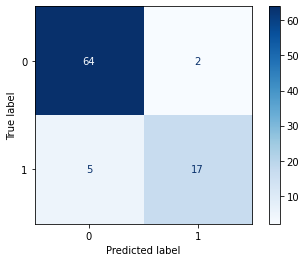

In [29]:
plot_confusion_matrix(model, X_test_unseen, y_test_unseen, cmap=plt.cm.Blues)

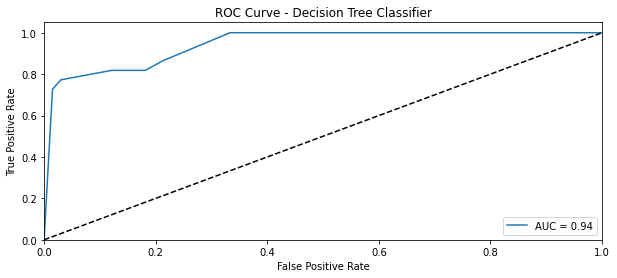

In [30]:
## ROC AUC Graph
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC = %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# for i in range(len(fpr)):
#     plt.text(fpr[i], tpr[i], "%0.2f" % thresholds[i])
#     plt.plot(fpr[i], tpr[i], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

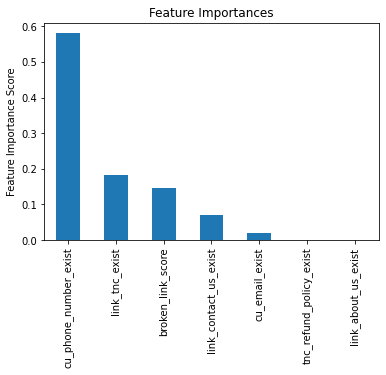

In [31]:
## Calculate feature importance by compute the (normalized) total reduction of the criterion brought by that feature
## Also known as Gini Importance
feat_score = model.tree_.compute_feature_importances()
feat_name = X_train.columns.values

feat_imp = pd.Series(index=feat_name, data=feat_score).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [32]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/model.pickle', 'wb'))